<a href="https://colab.research.google.com/github/mayursrt/dog-breed-identification/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. Data
The data we're using is from Kaggle's dog breed identification competition. You can get the data here:

https://www.kaggle.com/c/dog-breed-identification/data

3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


### Getting the workspace ready
First Import all the packages needed for the task:
* TensorFlow 2.x
* TensorFlow Hub

Also check if you're using a GPU.


In [1]:
# import packages and check their versions
import tensorflow as tf
import tensorflow_hub as hub
print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

TensorFlow version: 2.4.1
TensorFlow Hub version: 0.11.0


In [2]:
# check GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


**NOTE:** This project will not be able to run if there is no GPU available. If using Google Colab, Goto Runtime > Change Runtime Type > Select GPU.

### Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of the data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Breed Identification using Tensorflow/data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d530703b353991efcf62e7e10b8f7ee2  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

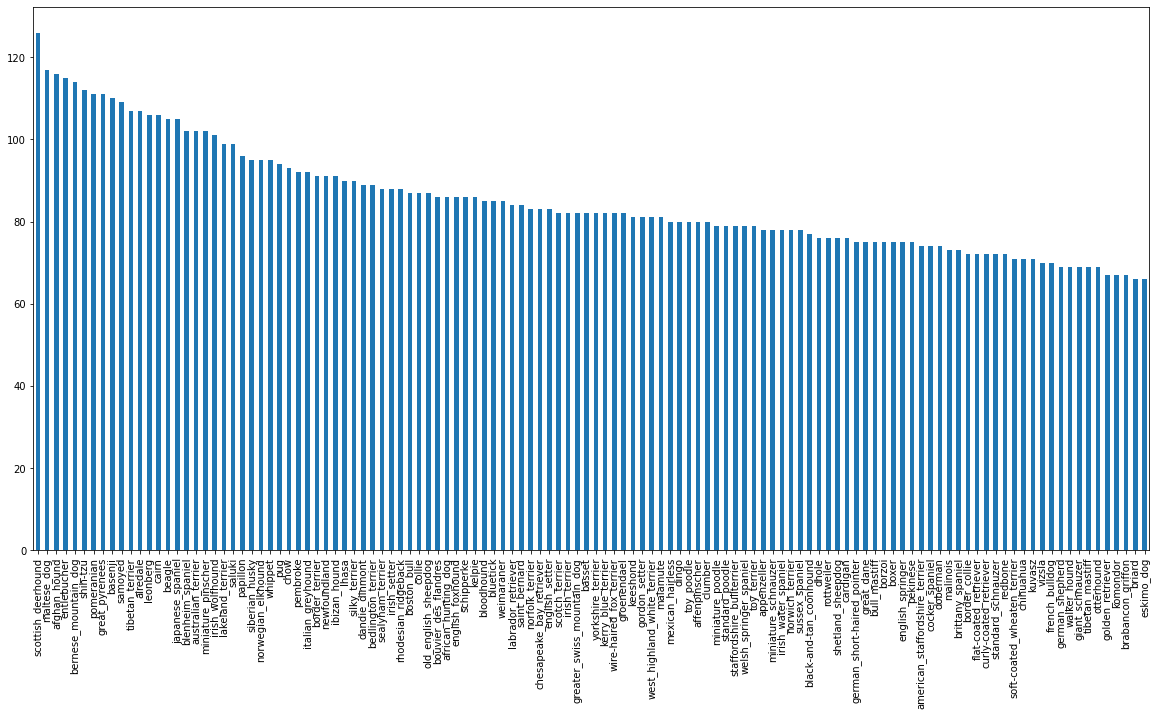

In [5]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

In [6]:
# median labels per breed to get distribution of data
labels_csv['breed'].value_counts().median()

82.0

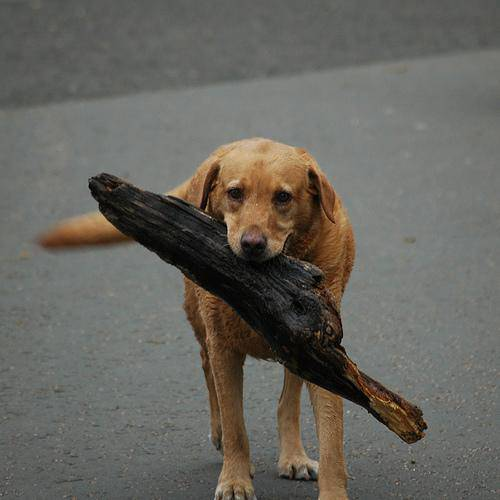

In [7]:
 # View an Image
 from IPython.display import Image
 Image('drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')



### Getting images and their labels
Get the list of all image file pathnames.

In [8]:
# create pathnames for image ids
filenames = ['drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/' + fname + '.jpg' for fname in labels_csv ['id']]
filenames[:10]

['drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Breed Id

In [9]:
# check if the number of filenames match the number of actual image files(this can be caused by incomplete upload of the files)
import os
if len(os.listdir('drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/')) == len(filenames):
  print('Filenames match actual amount of files..!!! you can proceed.')
else:
  print('Filenames do not match the actual amount of files..!! please try and reupload the data directory')

Filenames match actual amount of files..!!! you can proceed.


Preparing the labels

In [10]:
import numpy as np
# transforming labels so that they can be used.
labels = np.array(labels_csv['breed'])  ## can also use labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [11]:
#check length of labels
len(labels)

10222

In [12]:
# see if the number of labels match the length of filenames
if len(labels) == len(filenames):
  print('Filenames match actual amount of files..!!! you can proceed.')
else:
  print('Filenames do not match the actual amount of files..!! please try and reupload the data directory')

Filenames match actual amount of files..!!! you can proceed.


In [13]:
#find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [14]:
#len of unique breeds
len(unique_breeds)

120

In [15]:
#turning a label into a boolean array
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# likewise turning all labels in boolean array
labels_bool = [labels == unique_breeds for labels in labels]
labels_bool[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
# turning boolean array into integers #maybe not needed

print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(labels_bool[0].argmax())
print(labels_bool[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating validation set 
since we do not have validation set in our dataset, we need to create one so that we can run validation tests on the validation set.

we can use `train_test_split` for this job

In [18]:
# split into X and y

X = filenames
y = labels_bool

Starting off with ~1000 images since we need to reduce time taken for running the model

In [19]:
# set number of images used for experimenting
# if using jupyter notebook, set images number direct to a value
#NUM_IMAGES = 1000
# OR
# we can also use slider to set the number of images and increase them on the go if you are using Google Colab.
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10222, step:500}

In [20]:
# spliting data into train and validation set

from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing Images(turning Images into Tensors)
Since we might need to reuse the functionality of preprocessing the data, we need to create a function so that it is easy to reuse it.


To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
1. Use TensorFlow to read the file and save it to a variable, `image`
1. Turn our `image` (a jpg) into Tensors
1. Normalize our image (convert color channel values from from 0-255 to 0-1).
1. Resize the `image` to be a shape of (224, 224)
1. Return the modified `image`

In [21]:
# lets look how image looks in a numpy array vs in a tensor
from matplotlib.pyplot import imread
image = imread(filenames[45])
# image in form of a numpy array
image[:2]

array([[[85, 66, 60],
        [86, 67, 61],
        [84, 65, 59],
        ...,
        [41, 26, 23],
        [48, 33, 30],
        [51, 36, 33]],

       [[85, 66, 60],
        [89, 70, 64],
        [88, 69, 63],
        ...,
        [51, 36, 33],
        [58, 43, 40],
        [61, 46, 43]]], dtype=uint8)

In [22]:
#image in form of a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[85, 66, 60],
        [86, 67, 61],
        [84, 65, 59],
        ...,
        [41, 26, 23],
        [48, 33, 30],
        [51, 36, 33]],

       [[85, 66, 60],
        [89, 70, 64],
        [88, 69, 63],
        ...,
        [51, 36, 33],
        [58, 43, 40],
        [61, 46, 43]]], dtype=uint8)>

In [23]:
# creating the function

# Define image size
IMG_SIZE = 224

# write function
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # turn jpg image to numerical tensor with 3 color channels RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # convert colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize image
  image =  tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  # return image

  return image

### Turning data into batches 

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`.

In [24]:
# Create func to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [25]:
# Create function to turn all the data into batches.

# Define batch size
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # if the data is a test dataset, we will not have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is validation data, we don't need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # else training data 
  else:
    print('Creating train data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [26]:
# create training and validation data batches

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating train data batches...
Creating valid data batches...


### Visualizing Data Batches

The data is batches, now we can visualize these batches so to understand it better.



In [27]:
import matplotlib.pyplot as plt

# create func for viewing images in a data batch.
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # show image
    plt.imshow(images[i])
    # add title as image label
    plt.title(unique_breeds[labels[i].argmax()])
    # gridlines off
    plt.axis('off')

Since the train data is in the form of batches, we need to revert it back to numpy arrays to visualize it. We do it by using `next()` function which Return the next item from the iterator. That paired with `as_numpy_iterator()` which turns a dataset to numpy array, will give the desired results.

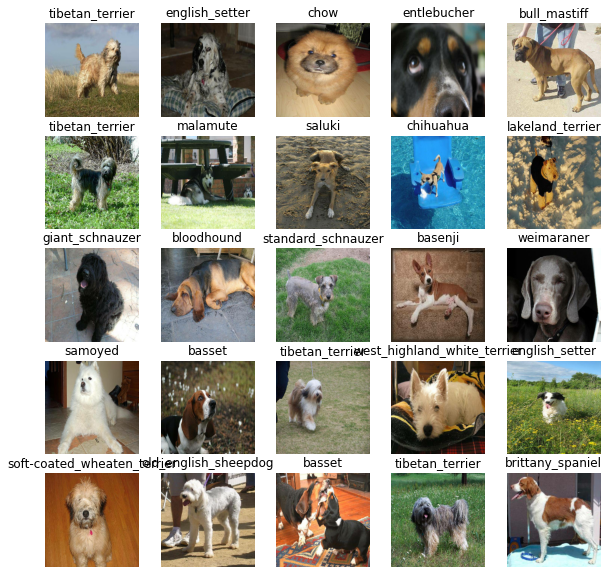

In [28]:
# turn data batch to numpy array.
## train_images, train_labels = next(train_data.as_numpy_iterator())
# Visualize training data.
## show_25_images(train_images, train_labels)

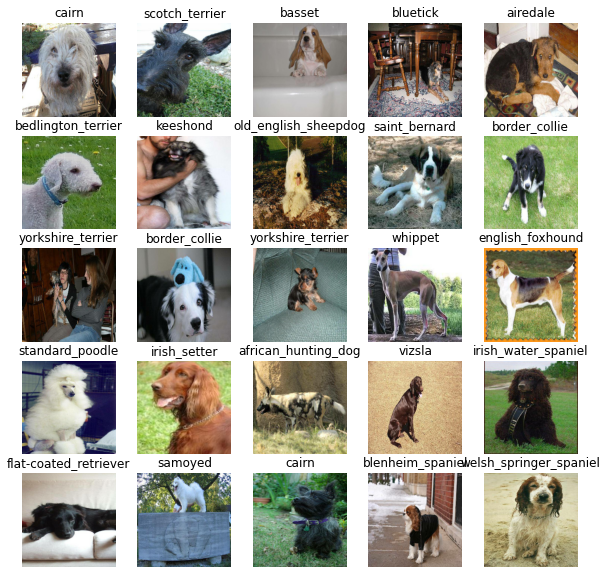

In [29]:
# turn data batch to numpy array.
## valid_images, valid_labels = next(valid_data.as_numpy_iterator())
# Visualize validation data.
## show_25_images(valid_images, valid_labels)

### Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
# Setup input shape of the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #model will get input in the form of [batch, height, width, colour channels]
# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # model will output boolean array of the label
# Model url from TensorFlow Hub
MODEL_URL = 